# Facebook 网络分析
本笔记本主要使用 NetworkX 库进行社交网络分析。具体来说，将研究十个人的 Facebook 圈子（好友列表），并从中提取各种有价值的信息。数据集可在此链接找到：[斯坦福 Facebook 数据集](http://snap.stanford.edu/data/ego-Facebook.html)。此外，众所周知，Facebook 网络是无向的，且没有权重，因为一个用户只能与另一个用户成为一次好友。从图分析的角度来看：
* 每个节点代表一个匿名的 Facebook 用户，该用户属于这十个好友列表之一。
* 每条边对应于属于该网络的两个 Facebook 用户之间的友谊。换句话说，两个用户必须在 Facebook 上成为好友，才能在特定网络中连接。

注意：节点 $0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980$ 是将被研究的好友列表节点。这意味着它们是本次分析的重点。这些节点被视为 `重点节点`。

## 导入包

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

## 分析
从 `data` 文件夹加载边数据，并保存到一个数据框中。每条边对应一行，每条边包含 `start_node` 和 `end_node` 两列。

In [2]:
facebook = pd.read_csv(
    "data/facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
facebook

start_node  end_node
0               0         1
1               0         2
2               0         3
3               0         4
4               0         5
...           ...       ...
88229        4026      4030
88230        4027      4031
88231        4027      4032
88232        4027      4038
88233        4031      4038

[88234 rows x 2 columns]

从 `facebook` 数据框创建图：

In [3]:
G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")

## 可视化图

让我们通过可视化图来开始探索。可视化在探索性数据分析中扮演着核心角色，有助于从定性的角度感受数据。

由于我们对数据的结构没有任何实际感觉，让我们从使用 `random_layout` 开始，这是布局函数中最快的一种。

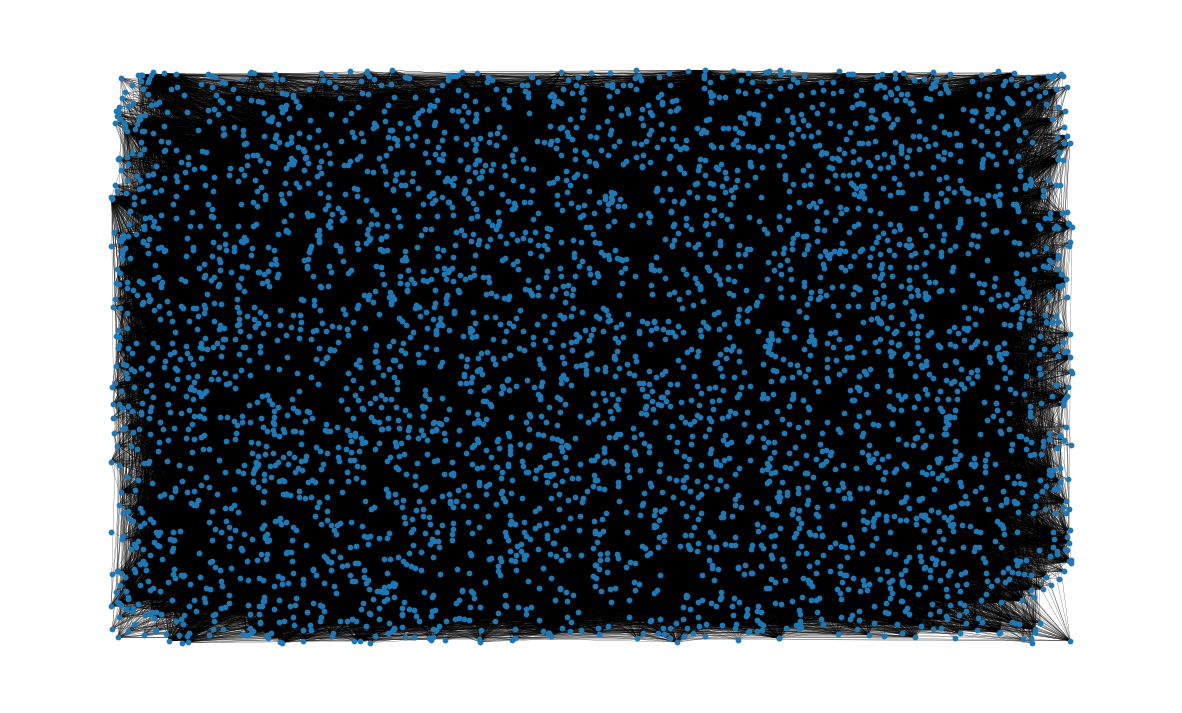

In [4]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

生成的图像...不太有用。这种类型的图可视化有时被称为“毛球”，因为重叠的边导致了一个纠缠的混乱。

很明显，如果我们想了解数据，我们需要在节点的定位上施加更多的结构。为此，我们可以使用 `spring_layout` 函数，这是 networkx 绘图模块的默认布局函数。`spring_layout` 函数的优势在于它考虑了节点和边来计算节点的位置。然而，缺点是这个过程在计算上更加昂贵，对于有数百个节点和数千条边的图来说可能会非常慢。

由于我们的数据集有超过 8 万条边，我们将限制 `spring_layout` 函数中使用的迭代次数，以减少计算时间。我们还将保存计算出的布局，以便将来用于可视化。

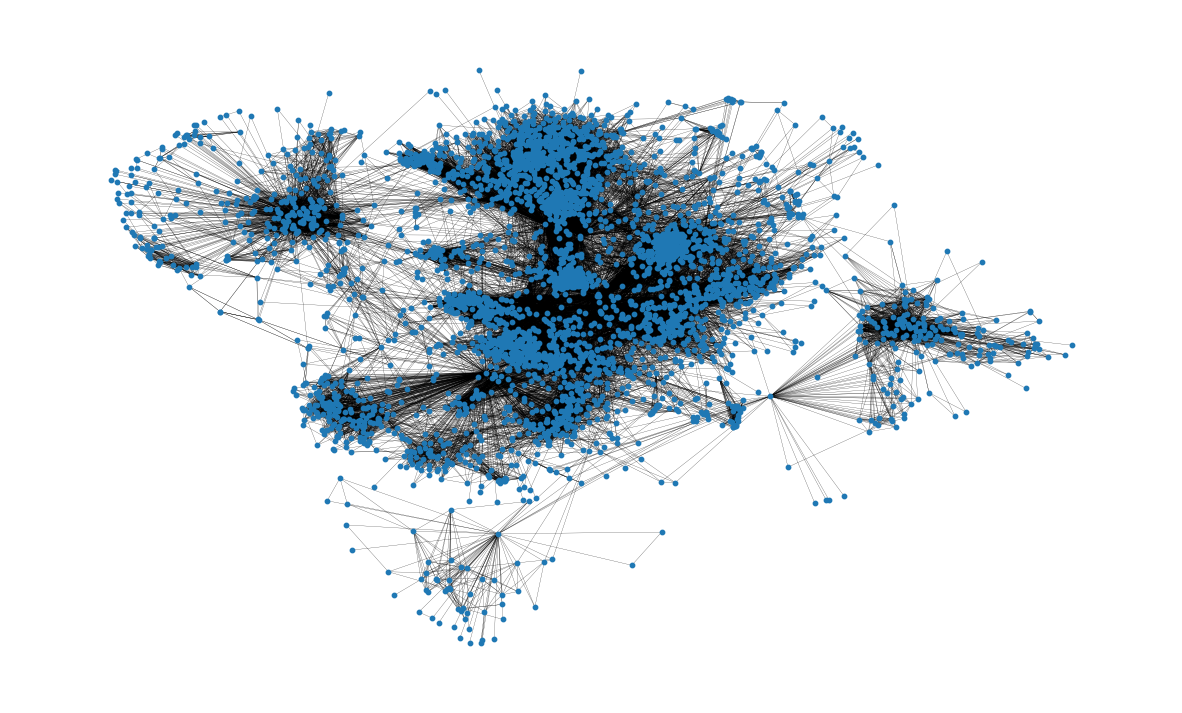

In [5]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

这个可视化比之前的更有用！我们已经可以从中了解网络的结构；例如，许多节点似乎高度连接，正如我们对社交网络的预期。我们还能感觉到节点倾向于形成集群。`spring_layout` 有助于给出集群的定性感觉，但它不是为可重复的定量集群分析设计的。我们将在[后面的分析](#clustering-effects)中重新审视评估网络集群。

## 基本拓扑属性
网络中的节点总数：

In [6]:
G.number_of_nodes()

4039

边的总数：

In [7]:
G.number_of_edges()

88234

此外，还可以看到节点的平均度数。
* 平均而言，一个节点连接到近 44 个其他节点，也称为节点的邻居。
* 这是通过创建所有节点度数的列表，并使用 `numpy.array` 找到创建列表的平均值来计算的。

In [8]:
np.mean([d for _, d in G.degree()])

np.float64(43.69101262688784)

关于图中的*路径*分布，有许多有趣的属性。例如，图的*直径*表示连接任意两个节点之间的最短路径中的最长路径。同样，平均路径长度给出了在网络中从一个节点到另一个节点需要经过的平均边数。这些属性可以通过 `nx.diameter` 和 `nx.average_shortest_path_length` 函数分别计算。但需要注意的是，这些分析需要计算网络中每对节点之间的最短路径：对于这种规模的网络来说，这可能相当耗时！由于我们对涉及网络中所有节点的最短路径长度的多个分析感兴趣，我们可以先计算一次并重用这些信息以节省计算时间。

让我们首先计算网络中所有节点对之间的最短路径长度：

In [9]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

`nx.all_pairs_shortest_path_length` 返回一个字典的字典，将一个节点 `u` 映射到网络中的所有其他节点，其中最内层的映射返回两个节点之间的最短路径长度。换句话说，`shortest_path_lengths[u][v]` 将返回任意两个节点 `u` 和 `v` 之间的最短路径长度：

In [10]:
shortest_path_lengths[0][42]  # 节点 0 和 42 之间的最短路径长度

1

现在让我们使用 `shortest_path_lengths` 来进行分析，首先计算 `G` 的*直径*。如果我们仔细查看 [`nx.diameter` 的文档字符串][nx_diameter_]，我们会发现它等价于图的最大*偏心率*。事实证明，`nx.eccentricity` 有一个可选参数 `sp`，我们可以传入预先计算的 `shortest_path_lengths` 以节省额外的计算：

In [11]:
# 这等价于 `diameter = nx.diameter(G)`，但由于我们重用了预先计算的最短路径长度，效率更高！
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
diameter

8

[nx_diameter_]: https://networkx.org/documentation/latest/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html

为了从一个节点连接到任何其他节点，我们最多需要经过 8 条边。

接下来，计算平均路径长度。同样，我们可以使用 `nx.average_shortest_path_length` 直接计算，但使用我们已经计算的 `shortest_path_length` 效率更高：

In [12]:
# 计算每个节点的平均最短路径长度
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# 所有节点的平均值
np.mean(average_path_lengths)

np.float64(3.691592636562027)

这表示所有节点对之间的最短路径长度的平均值：为了从一个节点到达另一个节点，平均大约需要经过 3.6 条边。

上述度量捕捉了网络的有用信息，但像平均值这样的指标仅代表分布的一个瞬间；查看分布本身通常也很有价值。同样，我们可以从预先计算的字典的字典中构建最短路径长度分布的可视化：

Text(0, 0.5, '频率 (%)')

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 30701 (\N{CJK UNIFIED IDEOGRAPH-77ED}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph

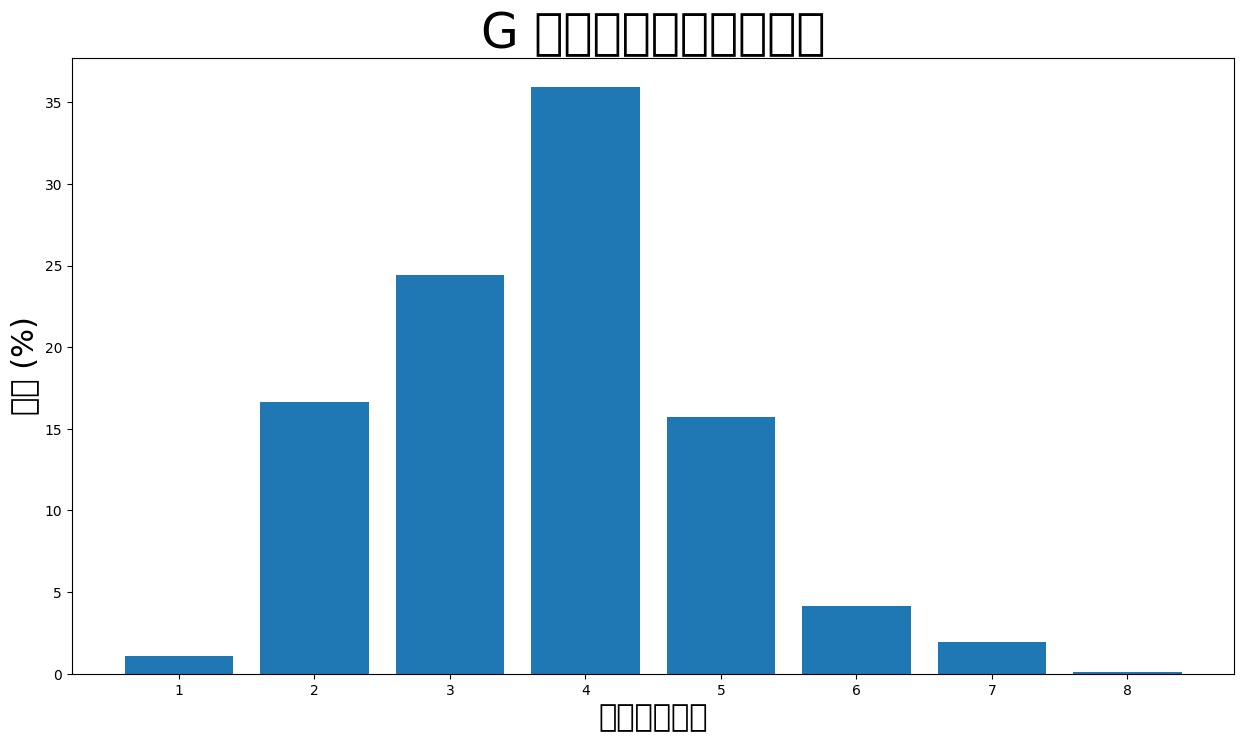

In [13]:
# 我们知道最短路径长度的最大值（直径），所以创建一个数组来存储从 0 到（包括）直径的值
path_lengths = np.zeros(diameter + 1, dtype=int)

# 提取两个节点之间最短路径长度的频率
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# 将频率分布表示为百分比（忽略长度为 0 的路径）
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# 将频率分布（忽略长度为 0 的路径）绘制为百分比
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "G 中最短路径长度的分布", fontdict={"size": 35}, loc="center"
)
ax.set_xlabel("最短路径长度", fontdict={"size": 22})
ax.set_ylabel("频率 (%)", fontdict={"size": 22})

大多数最短路径长度在 2 到 5 条边之间。此外，一对节点之间最短路径长度为 8（直径长度）的可能性极低，概率小于 0.1%。

图的密度在此计算。显然，图是一个非常稀疏的图，因为：$density < 1$

In [14]:
nx.density(G)

0.010819963503439287

图的连通分量数量如下。正如预期的那样，网络由一个巨大的连通分量组成：

In [15]:
nx.number_connected_components(G)

1

## 中心性度量
现在将检查 Facebook 图的中心性度量

### 度中心性
度中心性根据每个节点所持有的链接数量简单地分配一个重要性分数。在这种分析中，这意味着节点的度中心性越高，连接到该节点的边就越多，从而该节点拥有的邻居节点（Facebook好友）也就越多。实际上，一个节点的度中心性是它所连接的节点数的比例。换句话说，它是指特定节点所连接的网络的百分比，即与之成为好友的比例。
* 首先，我们找出具有最高度中心性的节点。具体来说，具有前8高度中心性的节点及其度中心性如下所示：

In [16]:
degree_centrality = nx.centrality.degree_centrality(
    G
)  # 将结果保存在一个变量中以便再次使用
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.258791480931154),
 (1684, 0.1961367013372957),
 (1912, 0.18697374938088163),
 (3437, 0.13546310054482416),
 (0, 0.08593363051015354),
 (2543, 0.07280832095096582),
 (2347, 0.07206537890044576),
 (1888, 0.0629024269440317)]

这意味着节点 $107$ 具有最高的度中心性，为 $0.259$，意味着这位Facebook用户与整个网络约26%的用户是好友。同样，节点 $1684, 1912, 3437$ 和 $0$ 也具有非常高的度中心性。然而，这是可以预料的，因为这些节点是我们所研究的Facebook圈子中的节点。非常有趣的是，节点 $2543, 2347, 1888$ 虽然我们没有研究他们的圈子，但它们也具有前8高的度中心性。换句话说，这三个节点在我们当前研究的圈子中非常受欢迎，意味着它们在这个网络中除了焦点节点外拥有最多的Facebook好友。
* 现在我们还可以看到具有最高度中心性的节点的邻居数量：

In [17]:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:8]

[(107, 1045),
 (1684, 792),
 (1912, 755),
 (3437, 547),
 (0, 347),
 (2543, 294),
 (2347, 291),
 (1888, 254)]

正如预期的那样，节点 $107$ 有 $1045$ 个Facebook好友，这是本次分析中任何Facebook用户拥有的最多好友数。此外，节点 $1684$ 和 $1912$ 在这个网络中拥有超过 $750$ 个Facebook好友。同样，节点 $3437$ 和 $0$ 在这个网络中分别拥有 $547$ 和 $347$ 个Facebook好友。最后，焦点节点中最受欢迎的两个朋友在这个网络中大约有 $290$ 个Facebook好友。

现在将绘制度中心性的分布图：

Text(0, 0.5, '计数')

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph

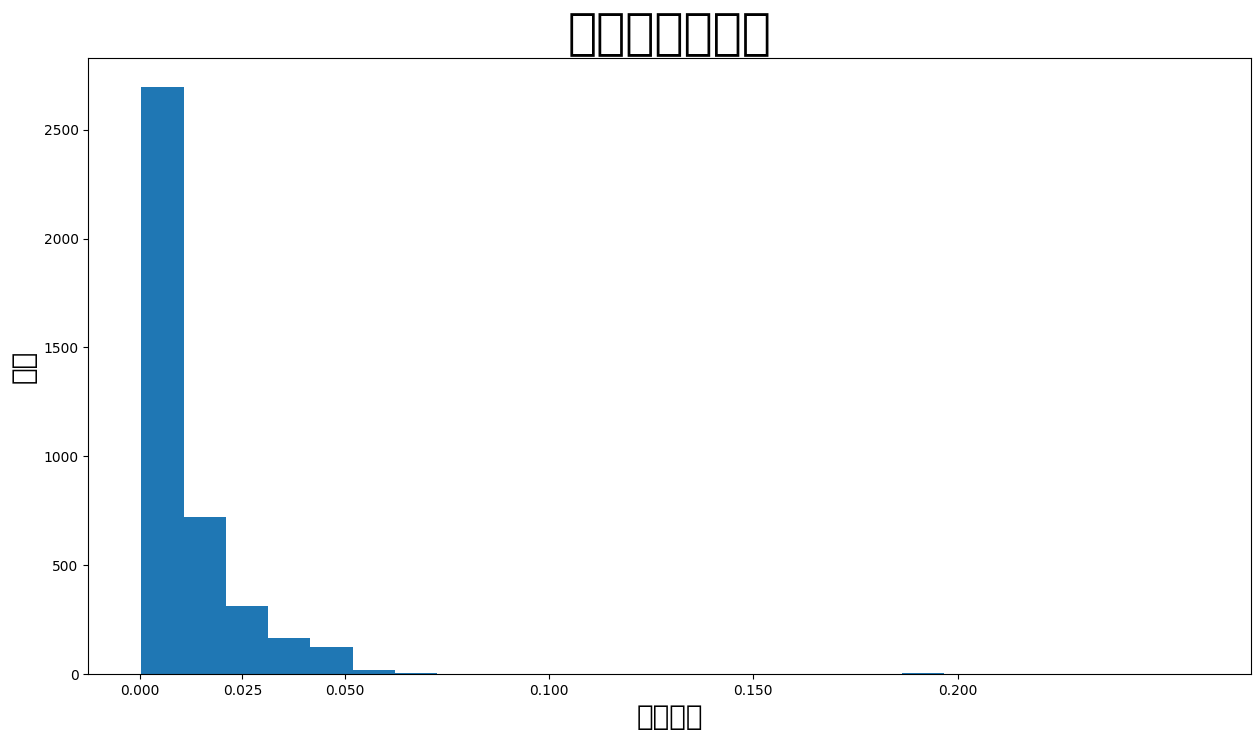

In [18]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # 设置x轴刻度
plt.title("度中心性直方图", fontdict={"size": 35}, loc="center")
plt.xlabel("度中心性", fontdict={"size": 20})
plt.ylabel("计数", fontdict={"size": 20})

可以看出，绝大多数Facebook用户的度中心性小于 $0.05$。事实上，大多数用户的度中心性小于 $0.0125$。实际上，这是有道理的，因为网络由特定节点的友列表组成，这些节点显然具有最高的度中心性。换句话说，由于仅使用了特定节点的友列表来创建这个特定网络，许多节点的度中心性极低，因为它们在这个网络中不是非常互联。

现在让我们从节点大小检查具有最高度中心性的用户：

(np.float64(-0.9991946166753769),
 np.float64(1.1078343337774277),
 np.float64(-1.1645995157957079),
 np.float64(0.7322139519453049))

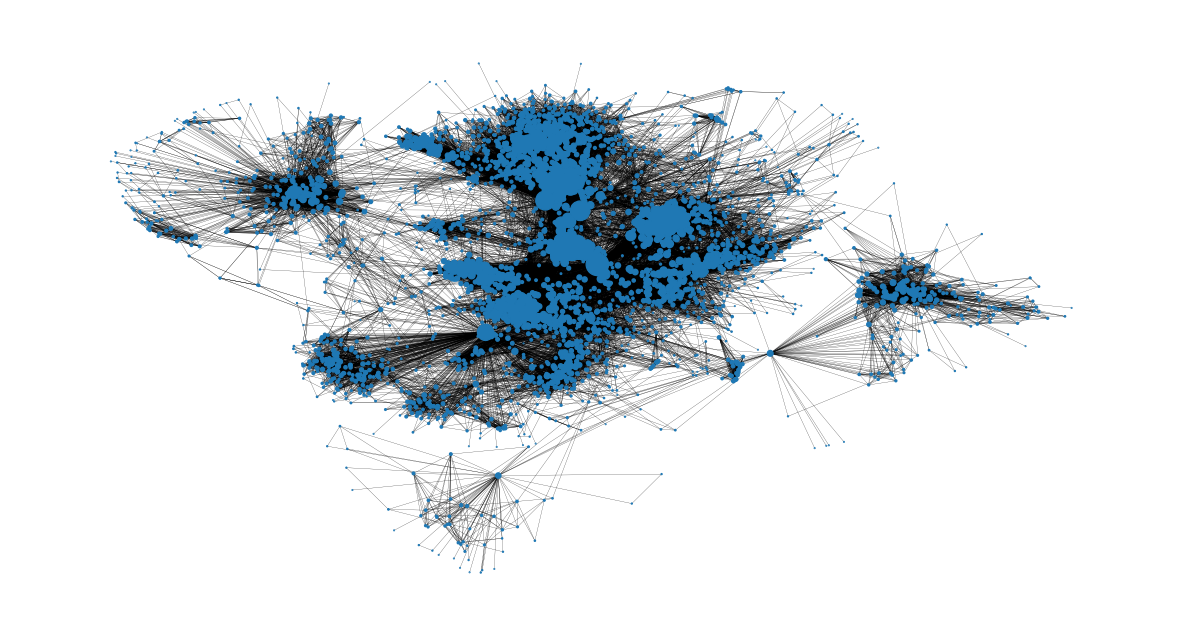

In [19]:
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # 设置节点大小以便于图形表示
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### 介数中心性
介数中心性衡量一个节点位于其他节点之间最短路径上的次数，即它充当桥梁的作用。详细来说，节点 $v$ 的介数中心性是所有任意两个节点（不包括 $v$）的最短路径中通过 $v$ 的比例。具体来说，在Facebook图中，这一度量与用户的潜在影响力有关。一个具有高介数中心性的用户充当了多个非好友用户之间的桥梁，因此有能力通过传递信息（例如发布内容或分享帖子）来影响他们，甚至通过用户的圈子将他们连接起来（这会降低用户的介数中心性）。
* 现在，我们将计算并显示具有前8高介数中心性的节点及其中心性值：

In [20]:
betweenness_centrality = nx.centrality.betweenness_centrality(
    G
)  # 将结果保存在一个变量中以便再次使用
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.4805180785560152),
 (1684, 0.3377974497301992),
 (3437, 0.23611535735892905),
 (1912, 0.2292953395868782),
 (1085, 0.14901509211665306),
 (0, 0.14630592147442917),
 (698, 0.11533045020560802),
 (567, 0.09631033121856215)]

查看结果，节点 $107$ 的介数中心性为 $0.48$，意味着它在几乎一半的总最短路径上。此外，结合度中心性的知识：
* 节点 $0, 107, 1684, 1912, 3437$ 同时具有最高的度和中介中心性，被称为 `焦点节点`。这表明这些节点不仅是网络中最受欢迎的，还能在网络中影响和传播信息。然而，这些节点中的一些朋友列表包含了整个网络，因此这一发现是预期的结果。
* 节点 $567, 1085$ 不是焦点节点，具有较高的中介中心性，但度中心性不是最高的。这意味着尽管这些节点不是网络中最受欢迎的用户，但它们在焦点节点的朋友圈中对信息的传播具有最大的影响力。
* 节点 $698$ 是一个 `焦点节点`，尽管其度中心性不是最高的，但具有非常高的中介中心性。换句话说，这个节点在 Facebook 上的朋友列表并不特别庞大。然而，该用户的整个朋友列表是网络的一部分，因此该用户可以通过充当中间人来连接网络中的不同圈子。

接下来，我们将绘制中介中心性的分布图：

Text(0, 0.5, '计数')

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20171 (\N{CJK UNIFIED IDEOGRAPH-4ECB}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20171 (\N{CJK UNIFIED IDEOGRAPH-4ECB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


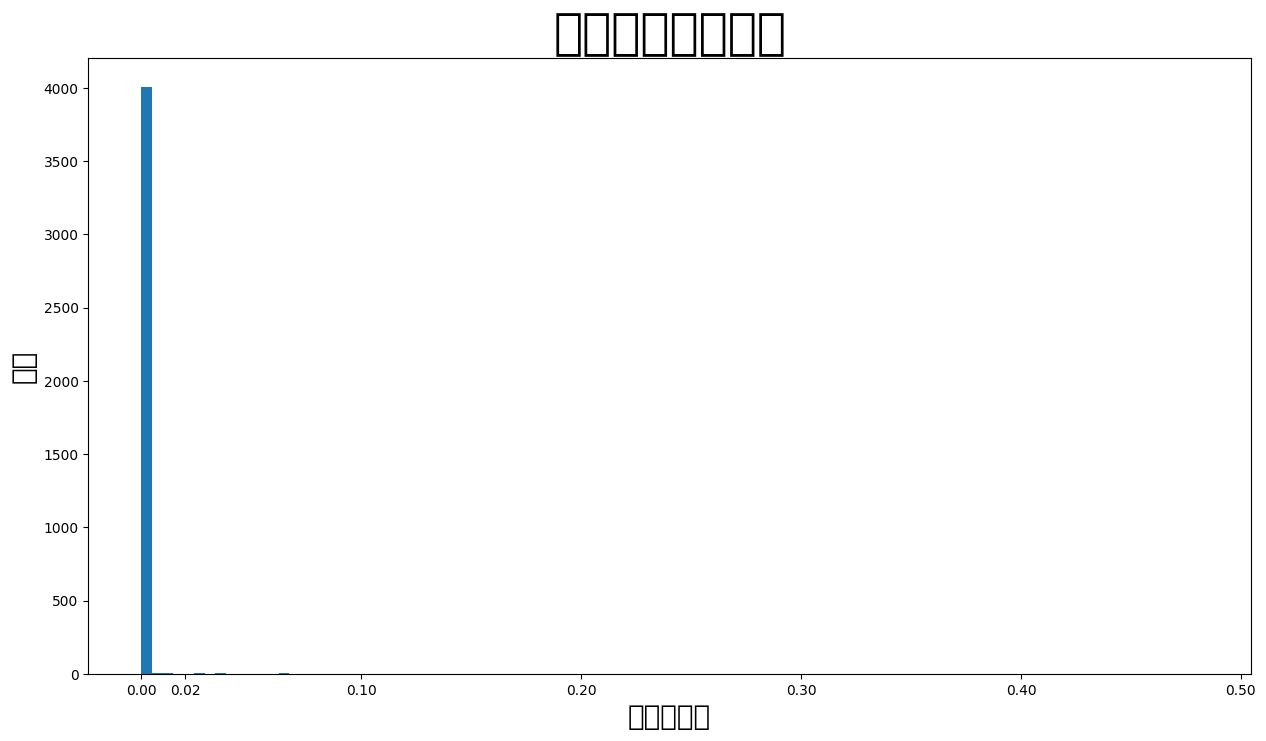

In [21]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # 设置 x 轴刻度
plt.title("中介中心性直方图", fontdict={"size": 35}, loc="center")
plt.xlabel("中介中心性", fontdict={"size": 20})
plt.ylabel("计数", fontdict={"size": 20})

正如我们所见，绝大多数中介中心性都低于 $0.01$。这是合理的，因为图非常稀疏，因此大多数节点在最短路径中不充当桥梁。然而，这也导致一些节点具有极高的中介中心性，例如节点 $107$ 的中介中心性为 $0.48$，节点 $1684$ 的中介中心性为 $0.34$。

我们还可以了解具有最高中介中心性的节点在网络中的位置。很明显，它们是连接不同社区的桥梁：

(np.float64(-0.9991946166753769),
 np.float64(1.1078343337774277),
 np.float64(-1.1645995157957079),
 np.float64(0.7322139519453049))

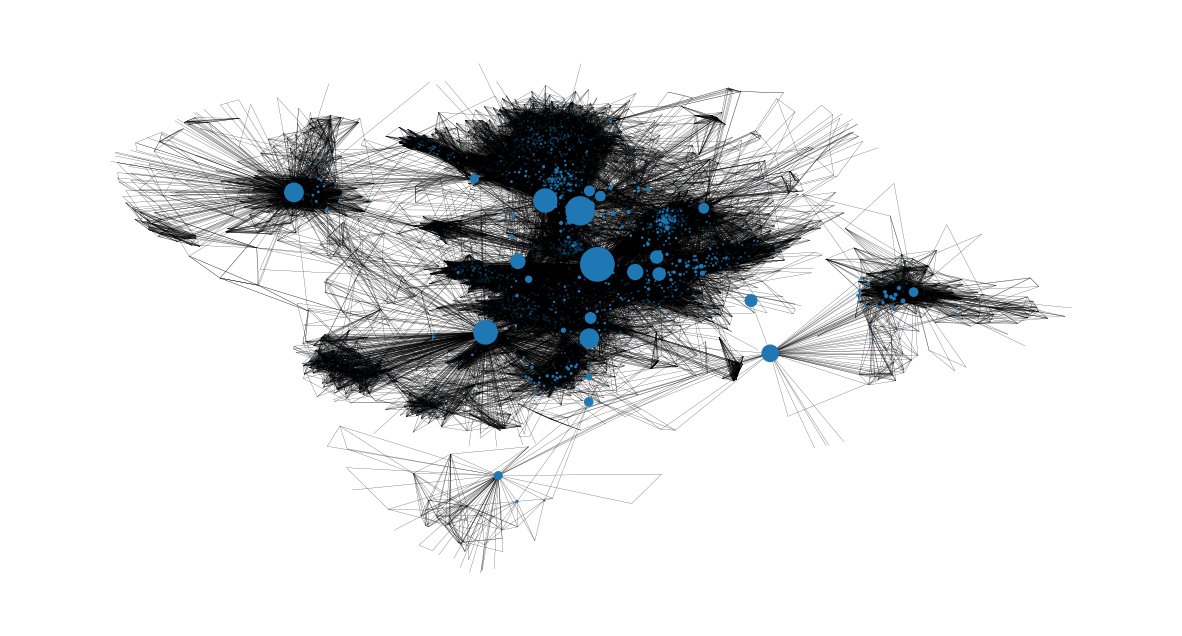

In [22]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]  # 设置节点大小以获得良好的图形表示
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### 接近中心性
接近中心性根据节点与网络中所有其他节点的“接近程度”对其进行评分。对于节点 $v$，其接近中心性衡量其到所有其他节点的平均距离。换句话说，$v$ 的接近中心性越高，它就越接近网络的中心。

接近中心性度量对于监测虚假信息（例如假新闻）或病毒（例如恶意链接，在这种情况下会控制 Facebook 账户）的传播非常重要。让我们以假新闻为例。如果具有最高接近中心性的用户开始传播一些假新闻信息（分享或创建帖子），整个网络将最快地被误导。然而，如果一个接近中心性非常低的用户尝试同样的事情，误导信息传播到整个网络的速度将慢得多。这是因为虚假信息首先需要到达一个具有高接近中心性的用户，该用户才能将其传播到网络的许多不同部分。
* 现在将找出具有最高接近中心性的节点：

In [23]:
closeness_centrality = nx.centrality.closeness_centrality(
    G
)  # 将结果保存在变量中以便再次使用
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.45969945355191255),
 (58, 0.3974018305284913),
 (428, 0.3948371956585509),
 (563, 0.3939127889961955),
 (1684, 0.39360561458231796),
 (171, 0.37049270575282134),
 (348, 0.36991572004397216),
 (483, 0.3698479575013739)]

检查具有最高接近中心性的用户，我们发现与之前的指标相比，他们之间的差距并不大。此外，节点 $107, 1684, 348$ 是仅有的在具有最高接近中心性的节点中发现的 `焦点节点`。这意味着一个拥有许多朋友的节点不一定靠近网络的中心。

此外，特定节点 $v$ 到任何其他节点的平均距离可以通过以下公式轻松计算：

$$\frac{1}{接近中心性(v)}$$

In [24]:
1 / closeness_centrality[107]

2.1753343239227343

从节点 $107$ 到随机节点的距离大约是两跳

此外，接近中心性的分布如下：

Text(0, 0.5, '计数')

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25509 (\N{CJK UNIFIED IDEOGRAPH-63A5}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 36817 (\N{CJK UNIFIED IDEOGRAPH-8FD1}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25509 (\N{CJK UNIFIED IDEOGRAPH-63A5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36817 (\N{CJK UNIFIED IDEOGRAPH-8FD1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


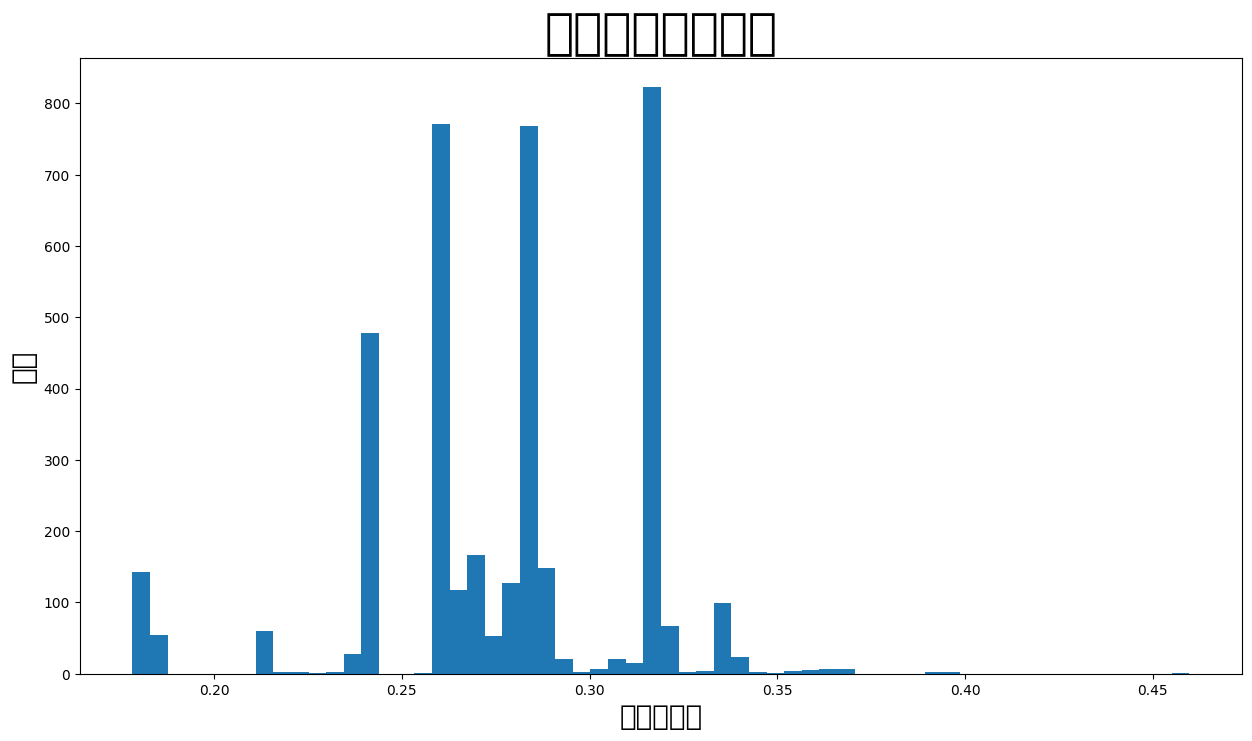

In [25]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("接近中心性直方图", fontdict={"size": 35}, loc="center")
plt.xlabel("接近中心性", fontdict={"size": 20})
plt.ylabel("计数", fontdict={"size": 20})

接近中心性分布在从 $0.17$ 到 $0.46$ 的不同值之间。实际上，大多数接近中心性值介于 $0.25$ 和 $0.3$ 之间。这意味着大多数节点相对接近网络中心，因此总体上接近其他节点。然而，也有一些社区位于更远的地方，这些节点的接近中心性值最低，如下所示：

(np.float64(-0.9991946166753769),
 np.float64(1.1078343337774277),
 np.float64(-1.1645995157957079),
 np.float64(0.7322139519453049))

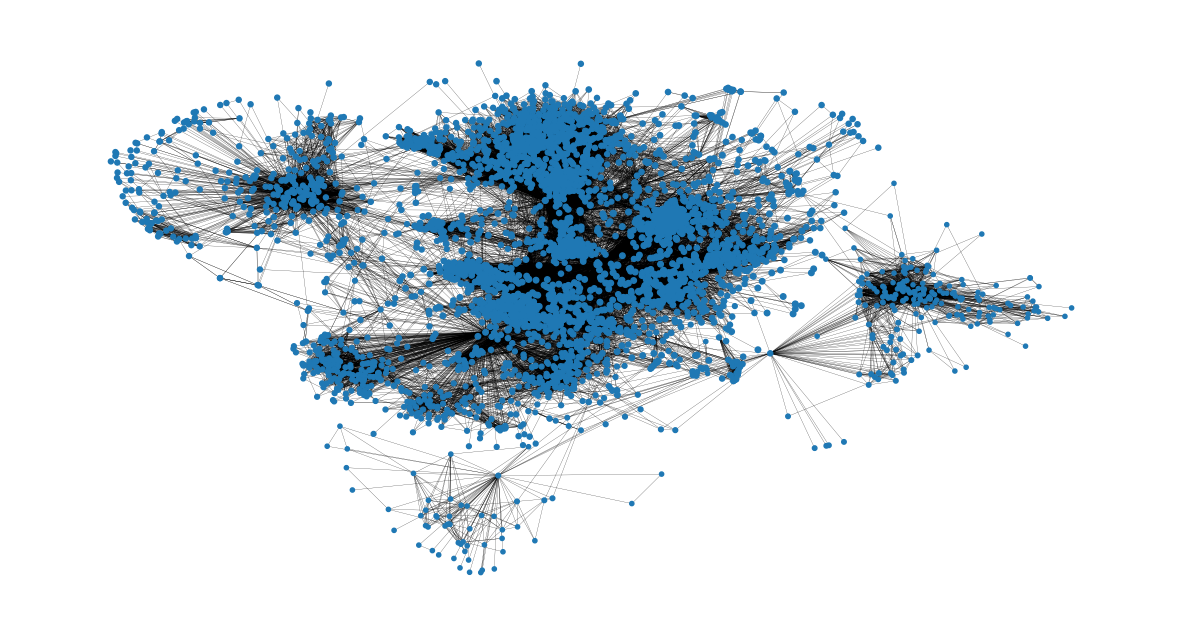

In [26]:
node_size = [
    v * 50 for v in closeness_centrality.values()
]  # 设置节点大小以获得良好的图形表示
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### 特征向量中心性
特征向量中心性是衡量一个节点与其他网络中重要节点连接程度的指标。它基于节点在网络内部的连接情况以及其连接的节点有多少链接等来衡量节点的影响力。这一指标可以识别出在整个网络中影响力最大的节点。高特征向量中心性意味着该节点连接到其他本身具有高特征向量中心性的节点。在这次 Facebook 分析中，该指标与用户对整个图的影响能力相关，因此具有最高特征向量中心性的用户是该网络中最重要的节点。

* 现在将检查具有最高特征向量中心性的节点：

In [27]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(
    G
)  # 将结果保存在变量中以便再次使用
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(1912, 0.09540696149067629),
 (2266, 0.08698327767886552),
 (2206, 0.08605239270584342),
 (2233, 0.08517340912756598),
 (2464, 0.08427877475676092),
 (2142, 0.08419311897991795),
 (2218, 0.0841557356805503),
 (2078, 0.08413617041724977),
 (2123, 0.08367141238206224),
 (1993, 0.0835324284081597)]

检查结果：
* 节点 $1912$ 具有最高的特征向量中心性，值为 $0.095$。该节点也是一个 `spotlight node`，无疑可以被认为是该网络中对整个网络影响力最大的节点。事实上，该节点还具有一些最高的度中心性和介数中心性，使其在其他节点中非常受欢迎且具有影响力。
* 节点 $1993, 2078, 2206, 2123, 2142, 2218, 2233, 2266, 2464$，尽管它们不是 spotlight nodes，但具有一些最高的特征向量中心性，大约在 $0.83-0.87$ 之间。非常有趣的是，所有这些节点都是首次被识别，意味着它们在这个图中既没有最高的度中心性、介数中心性或接近中心性。这导致了一个结论，即这些节点很可能与节点 $1912$ 相连，因此具有非常高的特征向量中心性。

检查这些节点是否与最重要的节点 $1912$ 相连，假设是正确的：

In [28]:
high_eigenvector_centralities = (
    sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)
)[
    1:10
]  # 第2到第10个具有最高特征向量中心性的节点
high_eigenvector_nodes = [
    tuple[0] for tuple in high_eigenvector_centralities
]  # 设置列表为 [2266, 2206, 2233, 2464, 2142, 2218, 2078, 2123, 1993]
neighbors_1912 = [n for n in G.neighbors(1912)]  # 列出所有与1912相连的节点
all(
    item in neighbors_1912 for item in high_eigenvector_nodes
)  # 检查列表 high_eigenvector_nodes 中的项目是否存在于列表 neighbors_1912 中

True

让我们检查特征向量中心性的分布：

Text(0, 0.5, '计数')

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtool

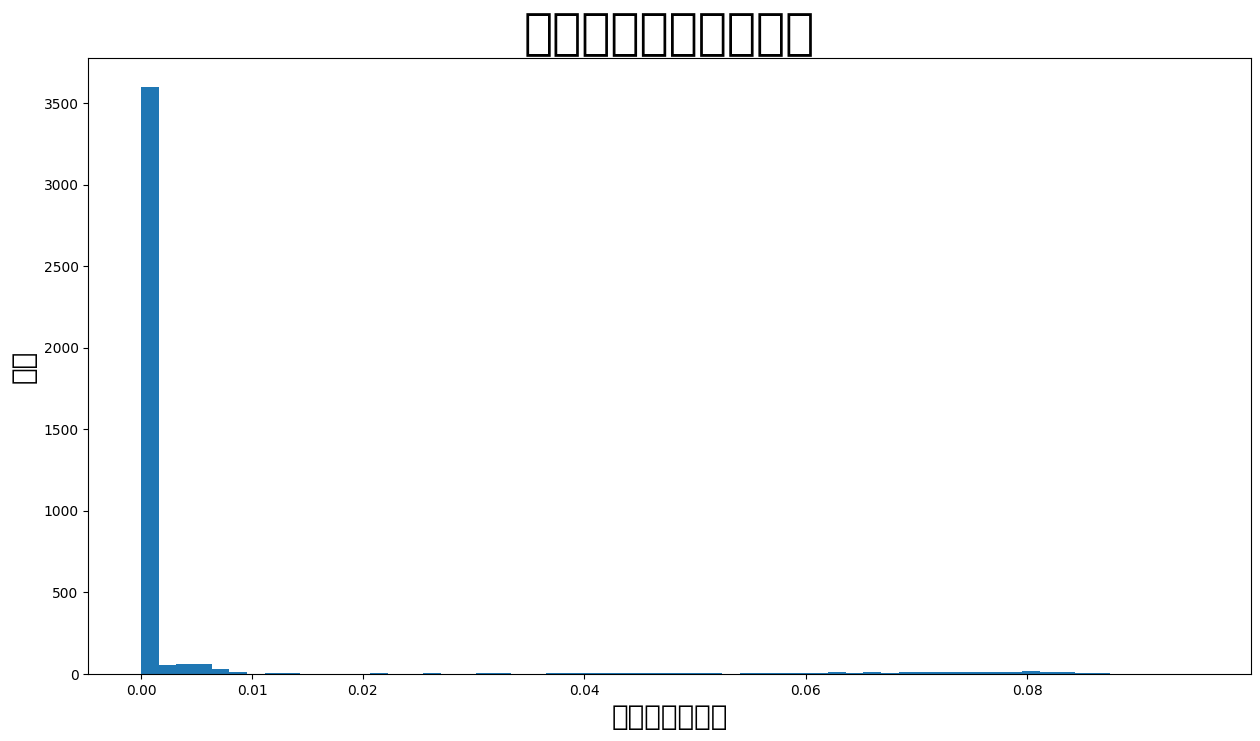

In [29]:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.xticks(ticks=[0, 0.01, 0.02, 0.04, 0.06, 0.08])  # 设置x轴刻度
plt.title("特征向量中心性直方图", fontdict={"size": 35}, loc="center")
plt.xlabel("特征向量中心性", fontdict={"size": 20})
plt.ylabel("计数", fontdict={"size": 20})

如分布直方图所示，绝大多数特征向量中心性低于 $0.005$，实际上几乎为 $0$。然而，我们也可以看到 x 轴上分布着不同值的特征向量中心性的小区间。

现在我们可以根据节点的大小来识别它们的特征向量中心性：

(np.float64(-0.9991946166753769),
 np.float64(1.1078343337774277),
 np.float64(-1.1645995157957079),
 np.float64(0.7322139519453049))

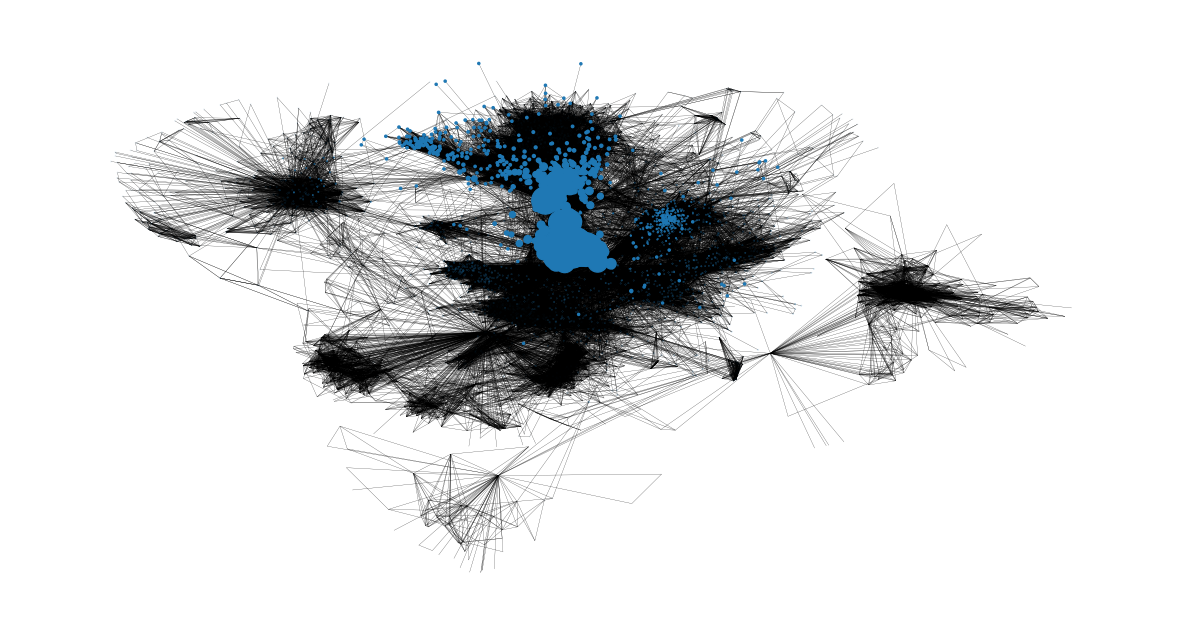

In [30]:
node_size = [
    v * 4000 for v in eigenvector_centrality.values()
]  # 设置节点大小以获得良好的图形表示
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## 聚类效应
节点 $v$ 的聚类系数定义为随机选择的 $v$ 的两个朋友互为朋友的概率。因此，平均聚类系数是所有节点的聚类系数的平均值。平均聚类系数越接近 $1$，图就越完整，因为只有一个巨大的组件。最后，这是三元闭包的一个标志，因为图越完整，通常会出现更多的三角形。

In [31]:
nx.average_clustering(G)

0.6055467186200876

现在将显示聚类系数分布：

Text(0, 0.5, '计数')

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages

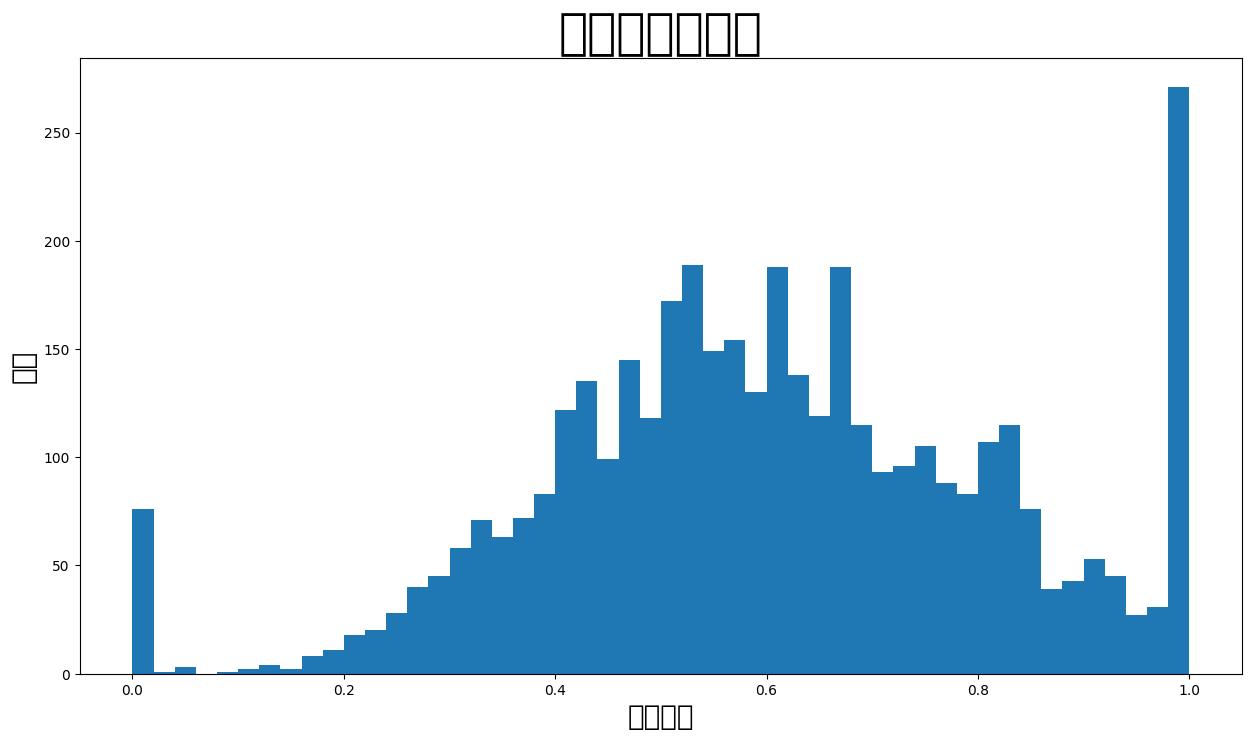

In [32]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50)
plt.title("聚类系数直方图", fontdict={"size": 35}, loc="center")
plt.xlabel("聚类系数", fontdict={"size": 20})
plt.ylabel("计数", fontdict={"size": 20})

使用了 50 个箱子来展示分布情况。计数最高的箱子涉及聚类系数接近 1 的节点，因为该箱子中有超过两百五十个节点。此外，聚类系数在 0.4 到 0.8 之间的箱子包含了绝大多数节点。

接下来，找出网络中唯一的三角形的数量：

In [33]:
triangles_per_node = list(nx.triangles(G).values())
sum(
    triangles_per_node
) / 3  # 除以 3 是因为每个三角形在每个节点上都被计算了一次

1612010.0

现在计算一个节点所属的平均三角形数量：

In [34]:
np.mean(triangles_per_node)

np.float64(1197.3334983906907)

由于有些节点属于大量三角形，中位数指标能让我们更好地理解：

In [35]:
np.median(triangles_per_node)

np.float64(161.0)

事实上，中位数值仅为 161 个三角形，而平均值约为 1197 个三角形。这意味着网络中的大多数节点属于极少数三角形，而有些节点则属于大量三角形（这些是极端值，增加了平均值）。

总之，高平均聚类系数和大量三角形是三元闭包的迹象。详细来说，三元闭包意味着随着时间的推移，新边倾向于在有两个或更多共同朋友的两个用户之间形成。这可以解释为 Facebook 通常会在用户与新朋友之间有很多共同朋友时向用户推荐新朋友。此外，还存在潜在的压力来源。例如，如果节点 A 与节点 B 和 C 是朋友，如果 B 和 C 彼此不是朋友，就会产生一些紧张。

## 桥
首先，图中连接两个节点 A 和 B 的边被认为是桥，如果删除该边会导致 A 和 B 位于两个不同的连通分量中。现在检查这个网络中是否存在桥：

In [36]:
nx.has_bridges(G)

True

实际上，网络中存在桥。现在将这些桥边保存到一个列表中并打印它们的数量：

In [37]:
bridges = list(nx.bridges(G))
len(bridges)

75

存在如此多的桥是因为这个网络仅包含焦点节点及其朋友。因此，焦点节点的一些朋友仅与一个焦点节点相连，使得该边成为桥。

此外，将局部桥边保存到一个列表中并打印它们的数量。详细来说，图中连接两个节点 C 和 D 的边是局部桥，如果其端点 C 和 D 没有共同的朋友。非常重要的一点是，作为桥的边也是局部桥。因此，这个列表也包含上述所有桥：

In [38]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

78

现在展示网络中的桥和局部桥。桥用红色表示，局部桥用绿色表示。黑色边既不是局部桥也不是桥。

* 很明显，所有的桥都涉及仅与一个焦点节点相连的节点（度为 1）

(np.float64(-0.9991946166753769),
 np.float64(1.1078343337774277),
 np.float64(-1.1645995157957079),
 np.float64(0.7322139519453049))

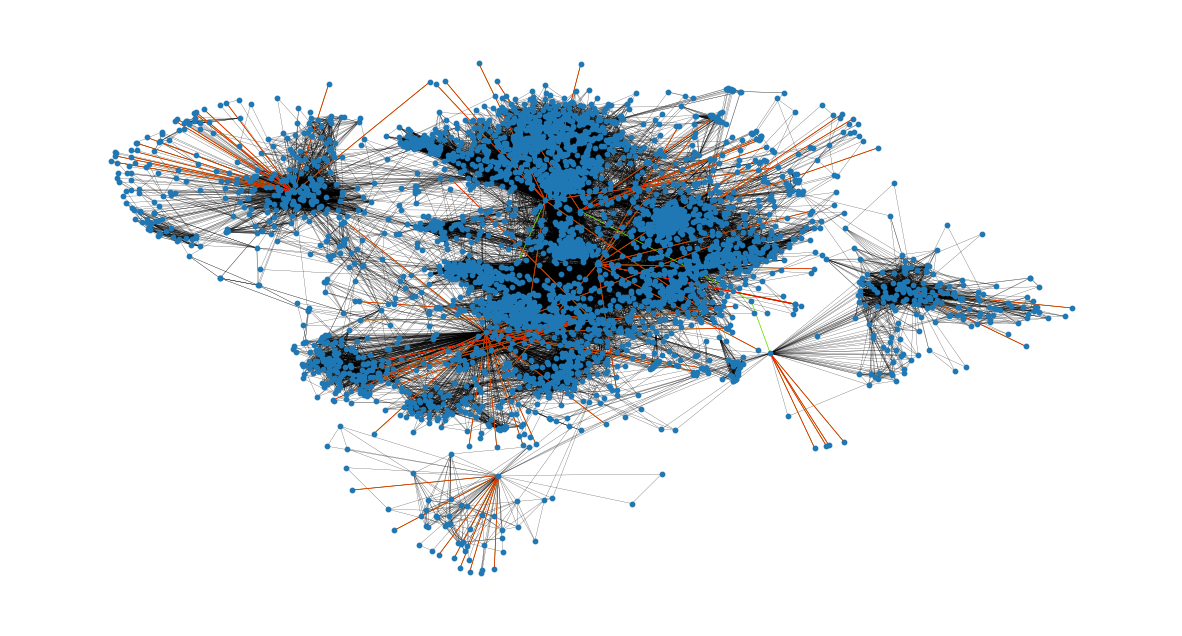

In [39]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # 绿色表示局部桥
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # 红色表示桥
plt.axis("off")

## 同配性
同配性描述了网络节点倾向于与某些方面相似的其他节点相连的偏好。
* 以节点度为依据的同配性通过两种方式计算：

In [40]:
nx.degree_assortativity_coefficient(G)

0.06357722918564943

In [41]:
nx.degree_pearson_correlation_coefficient(
    G
)  # 使用可能更快的 scipy.stats.pearsonr 函数。

0.06357722918564918

事实上，同配性系数是连接节点对之间度数的皮尔逊相关系数。这意味着它的取值范围从 -1 到 1。详细来说，正的同配性系数表示相似度数的节点之间的相关性，而负的表示不同度数的节点之间的相关性。
在我们的案例中，同配性系数约为 $0.064$，接近于 0。这意味着网络几乎是非同配的，我们无法根据节点的度数来关联链接的节点。换句话说，我们无法从一个用户的朋友的朋友数量（朋友度数）来推断该用户的朋友数量。这很合理，因为我们仅使用焦点节点的朋友列表，非焦点节点往往会拥有少得多的朋友。

## 网络社区
社区是一组节点，组内节点之间的连接边远多于组间连接。在本网络中，将使用两种不同的算法进行社区检测。

首先，使用半同步标签传播方法 [^1] 来检测社区。

该函数会自行确定将检测到的社区数量。现在将遍历这些社区，并创建一个颜色列表，为属于同一社区的节点分配相同颜色。同时，打印出社区的数量：

In [42]:
colors = ["" for x in range(G.number_of_nodes())]  # 初始化颜色列表
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # 创建随机 RGB 颜色
    counter += 1
    for node in list(
        com
    ):  # 为社区节点填充特定颜色到颜色列表中
        colors[node] = color
counter

44

详细来说，检测到了 $44$ 个社区。现在图中展示了这些社区。每个社区用不同的颜色表示，其节点通常位于相近的位置：

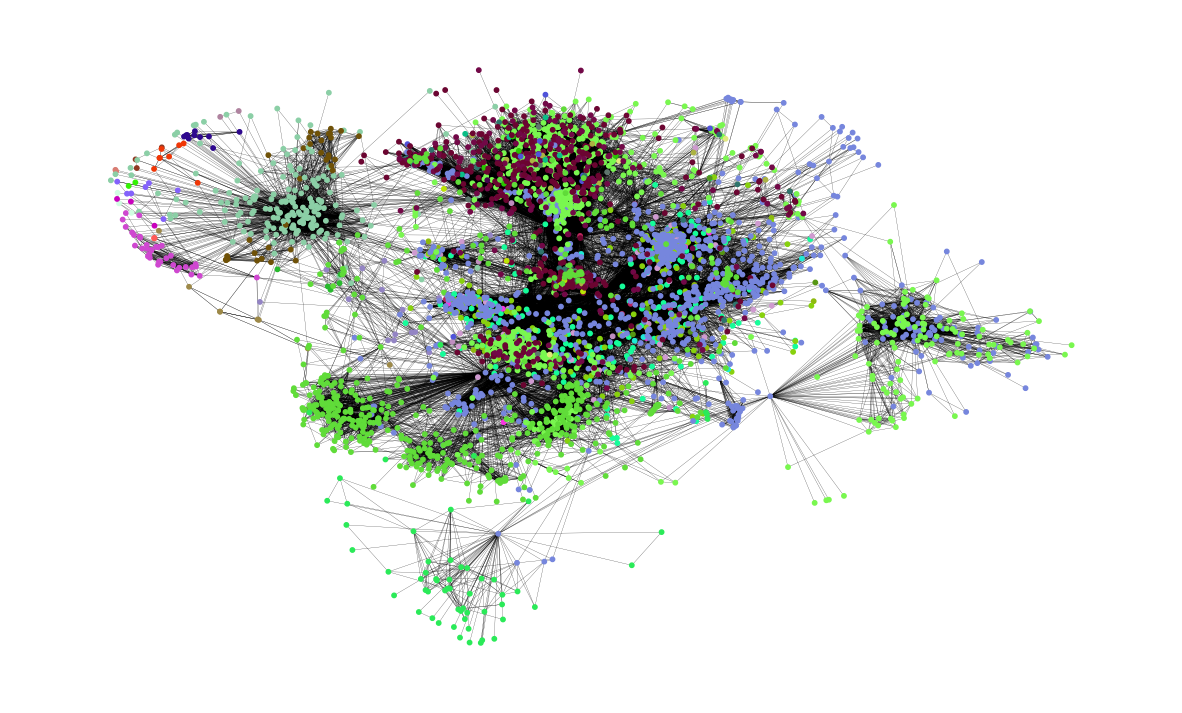

In [43]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)

* 接下来，使用异步流体社区算法 [^2]。

通过这个函数，我们可以决定要检测的社区数量。假设我们希望检测 $8$ 个社区。同样，将遍历这些社区，并创建一个颜色列表，为属于同一社区的节点分配相同颜色。

In [44]:
colors = ["" for x in range(G.number_of_nodes())]
for com in nx.community.asyn_fluidc(G, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # 创建随机 RGB 颜色
    for node in list(com):
        colors[node] = color

现在图中展示了这 $8$ 个社区。同样，每个社区用不同的颜色表示：

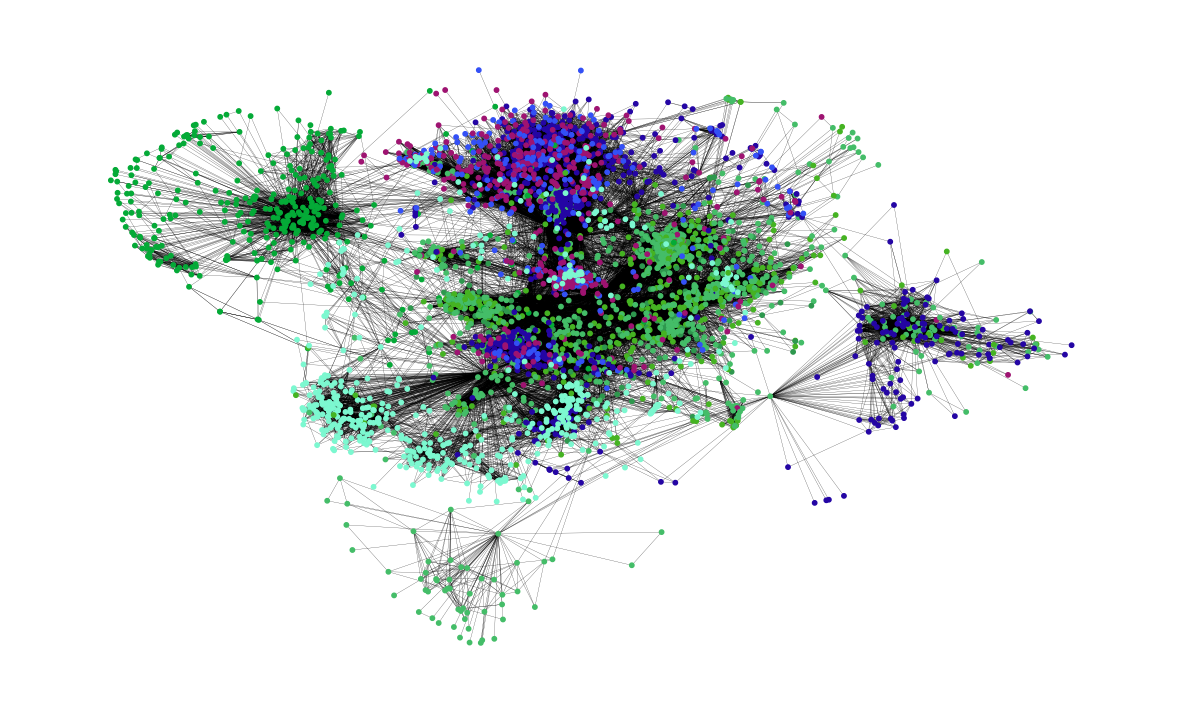

In [45]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)

## 参考文献

[^1]: [半同步标签传播](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.label_propagation_communities.html#networkx.algorithms.community.label_propagation.label_propagation_communities)

[^2]: [异步流体社区算法](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.asyn_fluid.asyn_fluidc.html#networkx.algorithms.community.asyn_fluid.asyn_fluidc)

[Cambridge-intelligence](https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/#:~:text=Centrality%20measures%20are%20a%20vital,but%20they%20all%20work%20differently.)